### **数据预处理**

**一、数据集label格式转化：xml to yolo**

In [1]:
import xml.etree.ElementTree as ET
import glob
import os
from tqdm import tqdm

**xml格式处理简单学习**

In [3]:
import xml.etree.ElementTree as ET
Annotations_path = "VOC2012/Annotations/*.xml"
for filename in glob.glob(Annotations_path):
    tree = ET.parse(filename)
    root = tree.getroot()
    print(root)
    break

<Element 'annotation' at 0x7582dc2e4040>


In [4]:
# 遍历元素
for child in root:
    print(f"元素名: {child.tag}, 属性: {child.attrib}, 文本: {child.text}")

元素名: filename, 属性: {}, 文本: 2011_007141.jpg
元素名: folder, 属性: {}, 文本: VOC2011
元素名: object, 属性: {}, 文本: 
		
元素名: segmented, 属性: {}, 文本: 0
元素名: size, 属性: {}, 文本: 
		
元素名: source, 属性: {}, 文本: 
		


In [5]:
# 查找指定的元素
filename = root.find('filename')
print(type(filename.text))
print((filename.text))

<class 'str'>
2011_007141.jpg


In [7]:
# 对于root有多个同名的tag，使用迭代
# 解析所有目标
objects = []
for obj in root.iter('object'):
    obj_data = {
        'name': obj.find('name').text,
        'bbox': [
            int(obj.find('bndbox/xmin').text),
            int(obj.find('bndbox/ymin').text),
            int(obj.find('bndbox/xmax').text),
            int(obj.find('bndbox/ymax').text)
        ]
    }
objects.append(obj_data)
print(objects)

[{'name': 'person', 'bbox': [260, 91, 356, 306]}]


**下面开始处理数据集**

将每个xml中的图片filename，物品的类别及bbox提取出来(一张图可能有多个)

In [15]:
import xml.etree.ElementTree as ET

class_map = {} # 定义类别字典，用于class2idx
class_nums = 0

# xml文件所处路径
Annotations_path = "VOC2012/Annotations/*.xml"

# 划分数据集为训练与测试集
f_train = open("train.txt","w",encoding = 'utf-8') # w为重写模式
f_test = open("test.txt","w",encoding = 'utf-8')

# 设置随机种子去划分
import random
all_xml_files = glob.glob(Annotations_path)
random.seed(666)
shuffled_data = random.sample(all_xml_files,len(all_xml_files)) # 打乱但不修改原数据
split_idx = int(len(all_xml_files) * 0.8)
train_xml_files = shuffled_data[:split_idx]
test_xml_files = shuffled_data[split_idx:]

# 处理训练集
for xmlname in train_xml_files:
    tree = ET.parse(xmlname)
    root = tree.getroot()
    img_name = root.find("filename").text
    f_train.write(f"{img_name} ")
    for obj in root.iter("object"):
        obj_name = obj.find("name").text
        if obj_name not in class_map:
            class_map[obj_name] = class_nums
            class_nums += 1
        x_min = obj.find("bndbox/xmin").text
        x_max = obj.find("bndbox/xmax").text
        y_min = obj.find("bndbox/ymin").text
        y_max = obj.find("bndbox/ymax").text
        f_train.write(f"{x_min} {y_min} {x_max} {y_min} {class_map[obj_name]} ") # 按特定顺序写入文件
    f_train.write("\n")

# 处理测试集
for xmlname in test_xml_files:
    tree = ET.parse(xmlname)
    root = tree.getroot()
    img_name = root.find("filename").text
    f_test.write(f"{img_name} ")
    for obj in root.iter("object"):
        obj_name = obj.find("name").text
        if obj_name not in class_map:
            class_map[obj_name] = class_nums
            class_nums += 1
        x_min = obj.find("bndbox/xmin").text
        x_max = obj.find("bndbox/xmax").text
        y_min = obj.find("bndbox/ymin").text
        y_max = obj.find("bndbox/ymax").text
        f_test.write(f"{x_min} {y_min} {x_max} {y_min} {class_map[obj_name]} ") # 按特定顺序写入文件
    f_test.write("\n")

# 关闭文件
f_train.close()
f_test.close()

# 检测类别数量是否符合
print(class_map)
print(class_nums) # 预期20类

{'person': 0, 'bird': 1, 'bus': 2, 'car': 3, 'sofa': 4, 'cat': 5, 'chair': 6, 'cow': 7, 'motorbike': 8, 'bicycle': 9, 'bottle': 10, 'diningtable': 11, 'dog': 12, 'pottedplant': 13, 'aeroplane': 14, 'train': 15, 'horse': 16, 'boat': 17, 'tvmonitor': 18, 'sheep': 19}
20


**二、生成Dataset，可用于迭代器生成**

In [2]:
from torch.utils import data
import torchvision
import torch

In [17]:
class YoloData(data.Dataset):
    """加载Yolo目标检测数据集"""
    def __init__(self,img_dir,label_file,num_classes = 20,
                 grid_size = 7,num_bboxes = 2,transforms = None):
        self.img_dir = img_dir
        self.label_file = label_file
        self.transforms = transforms # 图像变化

        self.normalize_transform = torchvision.transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std  = [0.229, 0.224, 0.225]
        ) # RGB格式的通道归一化参数

        self.images = []
        self.boxes = []
        self.labels = []

        # 对应论文里的S、B、C
        self.S = grid_size
        self.B = num_bboxes
        self.C = num_classes

        mode = torchvision.io.image.ImageReadMode.RGB # RGB格式

        # 解析数据集
        file = open(self.label_file,"r",encoding = 'utf-8')
        lines = file.readlines()
        loop = tqdm(lines,desc = "Extract dataset",total = len(lines))
        for line in loop:
            infomation = line.strip().split()
            self.images.append(torchvision.io.read_image(
                os.path.join(img_dir,infomation[0]),mode
            ))
            num_boxes = (len(infomation) - 1) // 5
            boxes = []
            labels = []
            for i in range(num_boxes):
                xmin = float(infomation[1 + 5 * i])
                ymin = float(infomation[2 + 5 * i])
                xmax = float(infomation[3 + 5 * i])
                ymax = float(infomation[4 + 5 * i])
                cls = float(infomation[5 + 5 * i])
                boxes.append([xmin,ymin,xmax,ymax])
                labels.append(cls)
            self.boxes.append(torch.tensor(boxes))
            self.labels.append(torch.LongTensor(labels)) # label为long
        file.close()

        # 原始数据集编码为可计算的形式
        self.raw_size = [(img.shape[1],img.shape[2]) for img in self.images]
        self.features = [self.img_transform(img) for img in 
                         tqdm(self.images,desc = 'Normalize img',total = len(self.images))]
        for i in tqdm(range(len(self.boxes)),desc = "Normalize bboxes",
                      total = len(self.boxes)):
            H,W = self.raw_size[i] # 注意这里用的是原来的比例(resize前的)
            self.boxes[i] /= torch.Tensor([W,H,W,H]).expand_as(self.boxes[i])
        self.targets = []
        for i in tqdm(range(len(self.boxes)),desc = "Generating targets",
                      total = len(self.boxes)):
            self.targets.append(self.encode(self.boxes[i],self.labels[i]))

    def encode(self,boxes,labels):
        """生成模型可计算的监督数据"""
        cell_size = 1.0 / self.S
        target = torch.zeros((self.S,self.S,self.B * 5 + self.C)) #(H,W,C)
        boxes_wh = boxes[:,2:4] - boxes[:,:2]
        boxes_xy = (boxes[:,2:4] + boxes[:,:2]) / 2.0
        for xy,wh,label in zip(boxes_xy,boxes_wh,labels):
            ij = (xy / cell_size).ceil() - 1.0
            i, j = int(ij[0]),int(ij[1])
            x0y0 = ij * cell_size
            xy_offset = (xy - x0y0) / cell_size # 计算相对格子的偏移量
            for b in range(self.B):
                s = b * 5
                target[j,i,s:s+2] = xy_offset
                target[j,i,s+2:s+4] = wh
                target[j,i,s + 4] = 1.0 # 置信度为1
            target[j,i,self.B * 5 + label] = 1.0 # 对应类别的概率为1
        return target.permute(2,0,1) #(C,H,W)

    def img_transform(self,img):
        """图像transform,可能包含各种增广及变化操作"""
        img = img.float() / 255
        if isinstance(self.transforms,torchvision.transforms.Compose):
            return self.transforms(img)
        elif isinstance(self.transforms,list):
            for transform in self.transforms:
                img = transform(img)
            return img

    def normalize_img(self,img):
        """图像归一化"""
        img = img.float()
        return self.transform(img.float() / 255)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.features[index],self.targets[index]

In [18]:
# transforms = torchvision.transforms.Compose(
#     [torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225]),
#      torchvision.transforms.Resize(448)]
# )
transforms = [
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225]),
    torchvision.transforms.Resize((448,448))
]
yolodata = YoloData("datasets/JPEGImages","datasets/train.txt",transforms = transforms)

Generating targets: 100%|██████████| 13700/13700 [00:03<00:00, 3917.46it/s]


In [19]:
print(len(yolodata.labels),yolodata.labels[0].shape,type(yolodata.labels[0]))
print(len(yolodata.features),yolodata.features[0].shape,type(yolodata.features[0]))
print(len(yolodata.boxes),yolodata.boxes[0].shape,type(yolodata.boxes[0]))
print(len(yolodata.targets),yolodata.targets[0].shape,type(yolodata.targets[0]))

13700 torch.Size([1]) <class 'torch.Tensor'>
13700 torch.Size([3, 448, 448]) <class 'torch.Tensor'>
13700 torch.Size([1, 4]) <class 'torch.Tensor'>
13700 torch.Size([30, 7, 7]) <class 'torch.Tensor'>


In [22]:
train_iter = data.DataLoader(yolodata,batch_size = 64)
for X,Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

torch.Size([64, 3, 448, 448])
torch.Size([64, 30, 7, 7])


In [30]:
print(yolodata.images[1].shape)
print(yolodata.raw_size[1])
print(yolodata.boxes[1])

torch.Size([3, 375, 500])
(375, 500)
tensor([[0.2280, 0.0267, 1.0000, 0.6453]])


<class 'torch.Tensor'>
torch.Size([3, 375, 500])
tensor([0.6200, 0.4960, 0.7740, 0.8347])
448 448
277 222 346 373


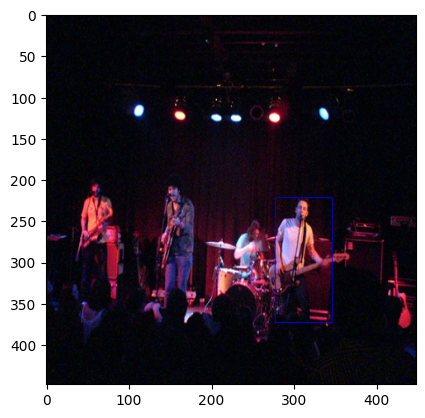

In [35]:
# 测试
idx = 0
img = yolodata.images[idx]
# img = yolodata.features[idx]
print(type(img))
print(img.shape)

import matplotlib.pyplot as plt
import numpy as np
import cv2
img_show = img.permute(1,2,0).numpy().astype(np.uint8)
img_show = cv2.resize(img_show,(448,448))
for box in yolodata.boxes[idx]:
    H,W = img_show.shape[:2]
    xmin,ymin,xmax,ymax = box
    xmin = int(xmin * W)
    xmax = int(xmax * W)
    ymin = int(ymin * H)
    ymax = int(ymax * H)
    print(box)
    print(W,H)
    print(xmin,ymin,xmax,ymax)
    cv2.rectangle(img_show,(xmin,ymin),(xmax,ymax),(0,0,255),thickness = 1)
plt.imshow(img_show)